# Header
## Small header
### Smaller header
#### Smallest

**Bold** *italic*

# Data Visualisation Assignment
Using a data set on earthquakes taken from USGS (U.S Geological Survey).

When analyzing earthquake data, you might want to explore aspects such as:

**Geographical Distribution**: Determine where most earthquakes occur, which regions are most affected, and identify earthquake-prone areas.

**Magnitude Trends**: Analyze the distribution of earthquake magnitudes to understand the frequency of small, moderate, and large earthquakes.

**Temporal Trends**: Explore how earthquake frequency changes over time. Are there seasonal patterns or long-term trends?

**Depth Analysis**: Investigate the depths at which earthquakes occur to gain insights into their origins.

**Magnitude vs. Depth**: Examine the relationship between earthquake magnitude and depth.

**Impact Analysis**: If available, consider data on the impact of earthquakes, such as casualties or economic damage.

**Time-Series Analysis**: Use time-series techniques to study earthquake patterns and predict future seismic activity if applicable.

In [23]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

df = pd.read_csv('all_month.csv')

## Basic statistics on the dataset
df.describe()

## Group data by the day of week
## numeric_only arguement prevents string values 
# print(df.groupby(["day"]).sum(numeric_only=True))

## Count
# print(df.groupby(["day"]).count())

# tips_by_day = df.groupby('day')['tip'].sum()
# print(tips_by_day.to_frame("tip (£)").reset_index())

# """fig, ax = plt.subplots(1,2)
# df.hist(column="total_bill",ax=ax[0])
# df.hist(column="total_bill",bins=20,ax=ax[1])


,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9662.000000,9662.000000,9662.000000,9661.000000,7316.000000,7316.000000,5868.000000,9662.000000,6691.000000,9661.000000,7283.000000,7306.000000
mean,40.912697,-116.671667,23.355603,1.565404,22.765856,117.215181,0.595249,0.288808,1.673778,2.099876,0.225285,16.652614
std,18.974728,65.423597,52.890429,1.202643,22.257144,66.359577,2.084116,0.266167,3.799421,4.939657,0.343733,27.449907
min,-65.899300,-179.994000,-3.430000,-1.020000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.991375,-152.311550,2.850000,0.770000,10.000000,68.000000,0.020028,0.100000,0.260000,0.400000,0.111000,6.000000
50%,38.836499,-122.788833,8.180000,1.340000,16.000000,99.000000,0.061570,0.180000,0.440000,0.700000,0.165206,10.000000
75%,57.997700,-116.590667,17.007500,2.000000,28.000000,151.475000,0.173125,0.460000,1.028817,1.530000,0.237541,18.000000
max,79.568100,179.977500,649.778000,7.100000,393.000000,357.000000,35.654000,2.820000,176.932676,87.300000,5.240000,504.000000


<Axes: >

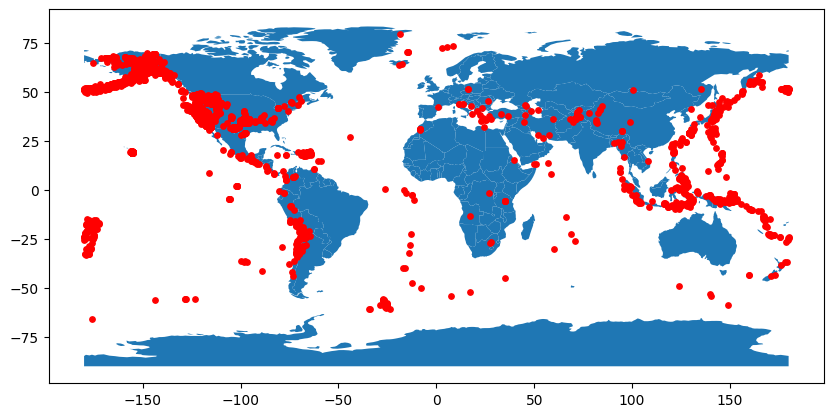

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

# Simple map that goes w/ geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)